# Practice Session PS05: Recommendation engines (Content-based)

For this assignment we will build and use a content-based recommender system for movies. This content-based recommender will take as input a database of users and ratings on movies.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Judith Camacho</font>

E-mail: <font color="blue">judith.camacho01@estudiant.upf.edu</font>

Date: <font color="blue">05/11/2020</font>

# 0. The MovieLens-1M dataset

One of the most widely used datasets for video/movies recommendation is the one built by the University of Minnesota, known as the [MovieLens DataSet](https://grouplens.org/datasets/movielens/1m/). In this assignment we are going to use the 1M version, that was released on February 2003.

The main characteristics are:
* All users selected had rated at least 20 movies
* Each user is represented by an id

The data is contained in three files: `ratings.dat`, `users.dat`, and `movies.dat`.

**RATINGS** are contained in `ratings.dat` in the following format: `UserID::MovieID::Rating::Timestamp`

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

**USERS** are described in `users.dat` in the following format: `UserID::Gender::Age::Occupation::Zip-code`

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this dataset.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

**MOVIES** are described in `movies.dat` in the following format: `MovieID::Title::Genres`

- Titles are identical to titles provided by the IMDB (including year of release)
- Genres are pipe-separated ("|") and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western
    
<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd   
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import scipy

# 1. Load and join the dataset

The following code, which you should leave as-is, loads the 3 dataset within three dataframes named `ratings`, `users`, and `movies` considering the data structure explained above.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [3]:
FILENAME_RATINGS = "ratings.dat"
FILENAME_USERS = "users.dat"
FILENAME_MOVIES = "movies.dat"

In [4]:
ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep='::', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

users = pd.read_csv(FILENAME_USERS, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
_ = users.set_index('user_id')

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
_ = movies.set_index('movie_id')

In [5]:
print("Ratings. Number of rows: ", ratings_raw.size)
print("Users. Number of rows: ", users.size)
print("Movies. Number of rows: ", movies.size)


Ratings. Number of rows:  4000836
Users. Number of rows:  30200
Movies. Number of rows:  11649


In [6]:
ratings_raw.head()


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
users.head()


,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [8]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Next we will join the dataframes into a single dataframe named "ratings". The equivalent of a database join is done with [pandas.merge](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) in Pandas, and it requires to identify common columns between the inputs that need to be joined. You can use:

```python
a = pd.merge(b, c, how='inner', on='...')
```

There the `on` parameter should indicate the name of the column in common between `b` and `c`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

I can join ratings_raw and users on user_id. And ratings_raw movies on movie_id.

In [9]:
ratings = pd.merge(ratings_raw, users, 'inner', on='user_id')
ratings = pd.merge(ratings, movies, 'inner', on='movie_id')

In [10]:
ratings.age.unique()

array([ 1, 56, 25, 50, 18, 45, 35], dtype=int64)

Create a function `find_movies` to easily find movies that contain a given keyword in its title. For instance `find_movies("Godfather", movies)` should print:

```
movie_id:   858, title: Godfather, The (1972)
movie_id:  1221, title: Godfather: Part II, The (1974)
movie_id:  2023, title: Godfather: Part III, The (1990)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "find_movies".</font>

In [11]:
def find_movies(keyword, df):
    new_df = df[df["title"].str.contains(keyword)].filter(["movie_id", "title"], axis=1).drop_duplicates()
    
    print(new_df.to_string(index=False))
#     print(new_df.apply(lambda row:print(f'movie_id:\t{row}, title: {row}')))

In [12]:
find_movies("Godfather", movies)

 movie_id                            title
      858            Godfather, The (1972)
     1221   Godfather: Part II, The (1974)
     2023  Godfather: Part III, The (1990)


# 2. Exploratory Data Analysis

## 2.1. "Ratings" variable

To have a clear understanding of the data, it is key to know the distribution of the main variables.
With the **.describe** function of Pandas, we can get a summary of the main statistics of a numeric variable:

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [13]:
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

It is key to know how ratings are distributed. Generate a plot with the ditribution of the ratings. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to plot a histogram of ratings. Include in the x axis the rating (1, 2, 3, 4, or 5) and in the y axis the probability of having that rating.</font>

,rating,quantity,prob
0,1,56174,0.056162
1,2,107557,0.107535
2,3,261197,0.261142
3,4,348971,0.348898
4,5,226310,0.226263


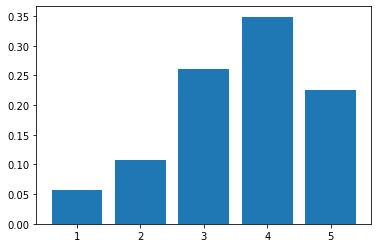

In [14]:
prob_rating = ratings.groupby(["rating"]).agg({"user_id": "count" }).reset_index()
prob_rating.columns =  ["rating", "quantity"]
prob_rating['prob'] = prob_rating["quantity"]/prob_rating["quantity"].sum()

plt.bar(prob_rating["rating"], prob_rating["prob"])
plt.xticks(np.arange(1,6,1))
prob_rating.head(5)

This distribution is possible a Beta distribution. We can see that the most probable rating is 4. 

## 2.2. Gender differences in rating

Men and women rate some movies differently. For each movie that has been rated by at least 50 men and 50 women, compute a `ratings_diff` value indicating what is the absolute difference in the average ratings men (`ratings['gender'] == 'M'`) and women (`ratings['gender'] == 'M'`) have given to it.

Then, print the 10 movies that have the larger `ratings_diff`.

There are many ways of doing this, the easiest is to create two dataframes named `ratings_male` and `ratings_female`, each one of them containig the number of ratings and average ratings men and women have given to each movie respectively, and then join them together and with the `movie` dataframe. Here are some of the ingredients to do that:

* `df[df['name'] == 'value']` returns a dataframe containing only rows for which column *name* has value *value*. For instance: `ratings[ratings['gender'] == 'F']` returns ratings by women.

* `df[df['name'] > value]` returns a dataframe containing only rows for which column *name* has a value larger than *value*. 

* `df[(df['col1'] > min1) & (df['col2'] > min2)]` returns only the rows of the original dataframe in which `col1` is larger than `min1` and `col2` is larger than `min2`.

* `df.groupby('identifier').column_name.agg(['count', 'mean'])` returns a dataframe in which instead of column named `column_name`, there are two columns containing the *count* and *average* for that column, grouped by the `identifier`. For instance: `ratings.groupby('movie_id').rating.agg(['count', 'mean']` return the count and average number of ratings for each movie_id.

* `df.rename(columns={'old_name': 'new_name'})` renames column `old_name` to `new_name`. This will be useful to avoid having repeated columns when joining. For instance, you may want to `df.rename(columns={'count': 'ratings_count_m', 'mean': 'ratings_mean_m'})` in the dataframe containing the average ratings for men.

* `pd.merge(a, b, how='inner', on='column_name')` as described before, joins dataframe `a` and `b` that have a common column named `column_name`.

* `df.sort_values(by='column_name', ascending=True)` sorts the dataframe by `column_name` in ascending ordering, or in descending ordering if `ascending=False`.

* `df.head(x)` prints the first x records of a dataframe

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to print the 10 movies that have the larger absolute difference in ratings between men and women; only include movies rated by at least 50 men and 50 women.</font>

In [15]:
ratings_grouped = ratings.groupby(['movie_id','gender', 'title']).agg(count=("user_id", "count"), rating=("rating", "mean")).reset_index()
ratings_grouped.head()
ratings_female = ratings_grouped[(ratings_grouped['gender'] == 'F') & (ratings_grouped['count'] >= 50)]

ratings_male = ratings_grouped[(ratings_grouped['gender'] == 'M') & (ratings_grouped['count'] >= 50)]

movies_50 = pd.merge(ratings_female, ratings_male, 'inner', on=['movie_id', "title"], suffixes=("_female", "_male"))




movies_50["ratings_diff"] = (movies_50["rating_female"] - movies_50["rating_male"]).apply(abs)
cols = ["movie_id", "title", "rating_female", "rating_male", "ratings_diff"]
movies_50 = movies_50[cols].sort_values(by='ratings_diff', ascending=False) #equivalent to filter with axis=1, ju 
movies_50.head(10)

,movie_id,title,rating_female,rating_male,ratings_diff
380,1088,Dirty Dancing (1987),3.790378,2.959596,0.830782
426,1201,"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
76,203,"To Wong Foo, Thanks for Everything! Julie Newm...",3.486842,2.795276,0.691567
929,2468,Jumpin' Jack Flash (1986),3.254717,2.578358,0.676359
194,506,Orlando (1993),3.862745,3.190476,0.672269
87,231,Dumb & Dumber (1994),2.697987,3.336595,0.638608
263,784,"Cable Guy, The (1996)",2.250000,2.863787,0.613787
474,1261,Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
544,1380,Grease (1978),3.975265,3.367041,0.608224
348,1021,Angels in the Outfield (1994),3.162500,2.580838,0.581662


We can see that women and men rate different some movies. 
For instance, Dirty Dancing (romance, musical) is rated higher by women. Even though this comment may sound misogynist, it's somehow common that women like romances and musicals more than men.
Also, Good, The Bad and The Ugly, The (1966) is highly rated by men. It is a western movie, old, so probably women don't like it that much because it may have male chauvinist connotations.


## 2.3. Genres distribution

Tipically, a movie genre is one of the most important descriptor for a movie recommendation engine: a basic assumption is that films in the same genre should have similar contents. Because of this, we have to know how this variable is, i.e. the values or categories, number or ratio of each categories, and so on.

Create a table indicating the list of all genres (column `movie['genres']` in this dataset).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Print a table listing the genres you see in this dataset, sorted from the most frequent to the least frequent. Notice that these frequencies may add up to more than the number of movies in the dataset, as a movie may have more than one genre.

Your output should look like this:

```python
[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Fantasy', 68],
 ['Western', 68],
 ['Film-Noir', 44]]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to obtain the frequency of each genre, check that it returns the same result as above.</font>

In [16]:
ratings["genres_arr"] = ratings.genres.str.split("|")
keyword_occurences = ratings.explode("genres_arr")
keyword_occurences = keyword_occurences.groupby(["genres_arr"]).agg(count=("genres_arr", "count")).reset_index()
keyword_occurences = keyword_occurences.values.tolist()
print(keyword_occurences)

[['Action', 257457], ['Adventure', 133953], ['Animation', 43293], ["Children's", 72186], ['Comedy', 356580], ['Crime', 79541], ['Documentary', 7910], ['Drama', 354529], ['Fantasy', 36301], ['Film-Noir', 18261], ['Horror', 76386], ['Musical', 41533], ['Mystery', 40178], ['Romance', 147523], ['Sci-Fi', 157294], ['Thriller', 189680], ['War', 68527], ['Western', 20683]]


Visualizing this data can help us better understand the distribution of genres. A useful visualization in some cases is a word cloud. We will use a [WordCloud Library](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) by Andreas Mueller.

The next code generates a word cloud. You can leave as-is or optionally pimp it up.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

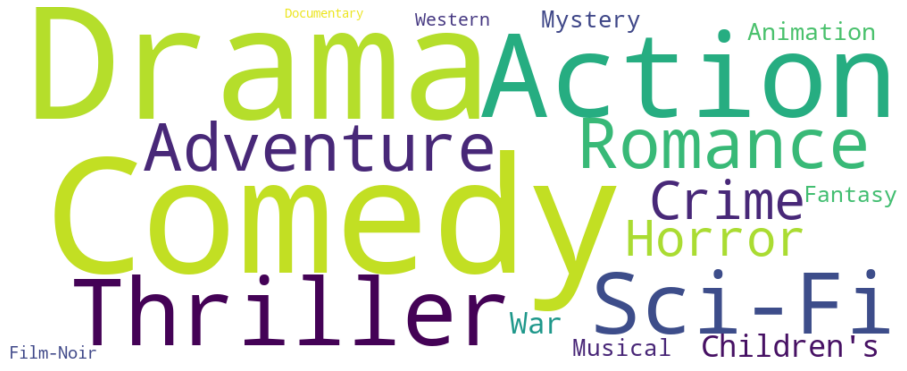

In [17]:
# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

The genres that appear the most are Drama, Comedy and Action. I think that socially, these kind of genres are the most amusing ones so people like them all (productors tend to do it because thay know the audience will like it).

# 3. Content-based recommendation

A content-based recommender works with data that describes the movie (or content). In our case, we will mainly use the genres that describes each movie. Our assumption is that films in the same genres should have similar contents and therefore are more likely to be recommended.

We *could* extend the content-based taking into account the title or any other text-based characteristics of the movie. We could also extend it using other attributes of the movie, even if they are not text. Content-based recommendations just means that we somehow compute the similarity between the items and then recommend the most similar items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 3.1. Compute TF-IDF vectors

**Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are techniques used in information retrieval to determine the **importance** of a word. In our use case, content-based recommendation, TF-IDF will be used to measure the importance of each genre in each movie. 

TF is simply the frequency of a word in a document, IDF is the inverse of the document frequency among the whole corpus of documents. Usually, TF and IDF are combined to measure the relevance of a word or term across different documents.

In a nutshell, TF-IDF weights infrequent words (in our case genres) more heavily. This means that two movies that share many uncommon genres will be considered more similar than two movies that share many common genres.

The TF-IDF score is computed as:

**tfidf(keyword, document) = TF(keyword, document) x IDF(keyword)**

Where:

* **TF(keyword, doc)** is the number of times the *keyword* appears in the *document*
* **IDF(keyword)** is **log(N/docfreq(keyword))** where **N** is the total number of documents and **docfreq(keyword)** is the number of documents containing the **keyword**

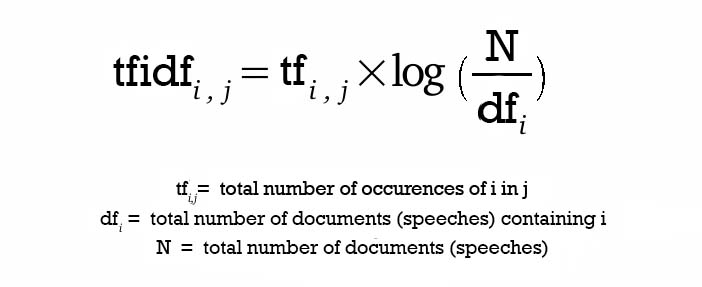

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

As a movie can belong to several genres, you should first break up the genre string into a string array.

Create a new column `genres_arr` in dataframe `movies` that contains the genres splitted in character "|".

Ensure this column has no "NaN", using [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html). Example: `df['colname'].fillna('').astype('str')`

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [18]:
# this code is slightly different from what asked, I have transformed it 
# into string instead of lists because the input of vectorizer should be a list of strings, not a list of lists and 
# it was giving me an error. Even though, the code to print what is asked should be:
# movies["genres_arr"] = movies.genres.fillna("").str.split("|")

movies["genres_arr"] = movies.genres.fillna("").str.split("|")
movies["genres_str"] = movies.genres_arr.str.join(" ")
movies.genres_arr.sample(10)


175                [Horror]
2453                [Drama]
2687               [Action]
546       [Comedy, Romance]
1990    [Children's, Drama]
3224        [Drama, Sci-Fi]
2922               [Action]
2172               [Comedy]
1618                [Drama]
1722          [Documentary]
Name: genres_arr, dtype: object

Verify by running the next cell. It should print:

```
Transformed: Animation|Children's|Comedy → ['Animation', "Children's", 'Comedy']
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [19]:
print("Transformed: %s → %s" % (movies['genres'][0], movies['genres_arr'][0]))

Transformed: Animation|Children's|Comedy → ['Animation', "Children's", 'Comedy']


Use the [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute tf-idf vectors on this column. Use `ngram_range=(1,2)` to consider one- and two-word genres. Store the resulting vectors in `tfidf_matrix`.

The resulting matrix should have 3,883 rows and 127 columns. Verify this using `tfidf_matrix.shape`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(movies.genres_str.values.tolist())

In [21]:
print(vectorizer.get_feature_names())
print(tfidf_matrix.shape)

['action', 'action adventure', 'action animation', 'action children', 'action comedy', 'action crime', 'action drama', 'action horror', 'action mystery', 'action romance', 'action sci', 'action thriller', 'action war', 'action western', 'adventure', 'adventure animation', 'adventure children', 'adventure comedy', 'adventure crime', 'adventure drama', 'adventure fantasy', 'adventure horror', 'adventure musical', 'adventure mystery', 'adventure romance', 'adventure sci', 'adventure thriller', 'adventure war', 'adventure western', 'animation', 'animation children', 'animation comedy', 'animation film', 'animation horror', 'animation musical', 'animation mystery', 'animation sci', 'children', 'children comedy', 'children drama', 'children fantasy', 'children horror', 'children musical', 'children romance', 'children sci', 'comedy', 'comedy crime', 'comedy documentary', 'comedy drama', 'comedy fantasy', 'comedy film', 'comedy horror', 'comedy musical', 'comedy mystery', 'comedy romance', 'c

## 3.2. Calculate most similar movies

As previously explained, the calculated TF-IDF from **genre** will be the variable to describe the content; i.e. in our case, the movie. 
The **similarity** will be measured considering the angle between the vectors generated after the TF-IDF process. Each movie becomes a vector of attributes in an **n-dimensional space** where the angles between the vectors **determines the similarity**. 
The method of calculating this relative measure is taking the cosine of the angle between two vectors. The vectors are length normalized and then the cosine calculation is simply the sum-product of vectors. 

For a more generic perspective, the next image is an example of several sentences represented by its vector space where Sentence 2 is more likely to be using Term 2 than using Term 1.

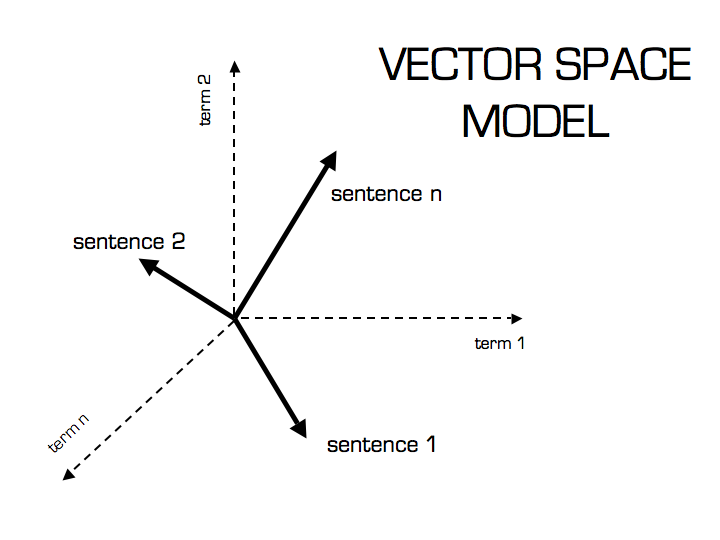

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

The next code, which you should leave as-is, uses sklearn's [linear_kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html) function, which is a fast way of computing these similarities on a matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [22]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.14193614 0.09010857 ... 0.         0.         0.        ]
 [0.14193614 1.         0.         ... 0.         0.         0.        ]
 [0.09010857 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         1.         0.3165589 ]
 [0.         0.         0.         ... 1.         1.         0.3165589 ]
 [0.         0.         0.         ... 0.3165589  0.3165589  1.        ]]


It is easy at this point to confuse movie_ids with row numbers. The following code, which you should leave as-is, will be helpful to you as it shows you how to obtain a row/column in this similarity matrix, and then how to go back to movie_ids from row/column numbers.

In this example, we ask for the similarities of all movies to movie with id 1 which is "Toy Story (1995)".

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [23]:
# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies.index, index=movies['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s %s" %
              (sim_scores[index_target], movies.iloc[index_target].movie_id, movies.iloc[index_target].title, movies.iloc[index_target].genres_str))
        
print_similarity_vector(1, cosine_sim)

1.000 1 Toy Story (1995) Animation Children's Comedy
0.142 2 Jumanji (1995) Adventure Children's Fantasy
0.090 3 Grumpier Old Men (1995) Comedy Romance
0.106 4 Waiting to Exhale (1995) Comedy Drama
0.235 5 Father of the Bride Part II (1995) Comedy
0.000 6 Heat (1995) Action Crime Thriller
0.090 7 Sabrina (1995) Comedy Romance
0.210 8 Tom and Huck (1995) Adventure Children's
0.000 9 Sudden Death (1995) Action
0.000 10 GoldenEye (1995) Action Adventure Thriller
0.073 11 American President, The (1995) Comedy Drama Romance
0.074 12 Dracula: Dead and Loving It (1995) Comedy Horror
0.827 13 Balto (1995) Animation Children's
0.000 14 Nixon (1995) Drama
0.000 15 Cutthroat Island (1995) Action Adventure Romance
0.000 16 Casino (1995) Drama Thriller
0.000 17 Sense and Sensibility (1995) Drama Romance
0.000 18 Four Rooms (1995) Thriller
0.235 19 Ace Ventura: When Nature Calls (1995) Comedy
0.000 20 Money Train (1995) Action
0.065 21 Get Shorty (1995) Action Comedy Drama
0.000 22 Copycat (1995) Cr

Create a function `genre_content_based_recommendations` that uses the similarity matrix and the list of movie titles to find the top-k most recommended movies for a given movie.

Python's `enumerate` function will be helpful. Look at the following example:

```python
similarities = [0.2, 0.7, 0.3, 0.4]
enumerated = list(enumerate(similarities))
sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
top_two_similarities = sorted_similarities[0:2]
for index, similarity in top_two_similarities:
    print("Element #%d with similarity %.1f" % (index, similarity))
```

The output will be: 

```
Element #1 with similarity 0.7
Element #3 with similarity 0.4
```

The function `genre_content_based_recommendations` should follow this template:

```python
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    # Replace this comment with code to produce top_similarities
    
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain movie_id, title, genres
        
        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [24]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]

    # Replace this comment with code to produce top_similarities
    sim_scores = list(similarities[index_source])
    enumerated = list(enumerate(sim_scores))
    top_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    
    recommendations = []
    for i in range(num_movies+1):
        index_target = top_similarities[i][0]
        similarity = top_similarities[i][1]

        # Replace this comment with code to obtain movie_id, title, genres

        recommendations.append({
                'movie_id': movies.iloc[index_target].movie_id,
                'title': movies.iloc[index_target].title,
                'genres': movies.iloc[index_target].genres,
                'similarity': similarity
            }
        )

    recommendations = pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])
    return recommendations[recommendations.movie_id!=movie_id]

In [25]:
genre_content_based_recommendations(1, movies, cosine_sim, 15)

,similarity,movie_id,title,genres
1,1.000000,1064,Aladdin and the King of Thieves (1996),Animation|Children's|Comedy
2,1.000000,2141,"American Tail, An (1986)",Animation|Children's|Comedy
3,1.000000,2142,"American Tail: Fievel Goes West, An (1991)",Animation|Children's|Comedy
4,1.000000,2354,"Rugrats Movie, The (1998)",Animation|Children's|Comedy
5,1.000000,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
6,1.000000,3114,Toy Story 2 (1999),Animation|Children's|Comedy
7,1.000000,3611,Saludos Amigos (1943),Animation|Children's|Comedy
8,1.000000,3751,Chicken Run (2000),Animation|Children's|Comedy
9,1.000000,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Animation|Children's|Comedy
10,0.869805,239,"Goofy Movie, A (1995)",Animation|Children's|Comedy|Romance


In [26]:
genre_content_based_recommendations(858, movies, cosine_sim, 15)

,similarity,movie_id,title,genres
0,1.000000,42,Dead Presidents (1995),Action|Crime|Drama
1,1.000000,493,Menace II Society (1993),Action|Crime|Drama
3,1.000000,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
4,1.000000,2023,"Godfather: Part III, The (1990)",Action|Crime|Drama
5,1.000000,2194,"Untouchables, The (1987)",Action|Crime|Drama
6,1.000000,2912,"Limey, The (1999)",Action|Crime|Drama
7,0.848618,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
8,0.848618,2540,"Corruptor, The (1999)",Action|Crime|Drama|Thriller
9,0.825405,284,New York Cop (1996),Action|Crime
10,0.825405,998,Set It Off (1996),Action|Crime


<font size="+1" color="red">Replace this cell with code to get the list of recommendation for some movie you are familiar with. Indicate which of the top recommendations are good recommendations, and which are, in your opinion, not good or bad recommendations. Indicate how you would improve the content-based recommendations, based on what we discussed in class about content-based recommendations.</font>

In [39]:
movie_chosen = movies[movies["title"]=="Last of the Mohicans, The (1992)"]
movie_chosen

,movie_id,title,genres,genres_arr,genres_str
1385,1408,"Last of the Mohicans, The (1992)",Action|Romance|War,"[Action, Romance, War]",Action Romance War


In [40]:
genre_content_based_recommendations(1408, movies, cosine_sim, 15)

,similarity,movie_id,title,genres
1,0.744687,976,"Farewell to Arms, A (1932)",Romance|War
2,0.744687,1071,For the Moment (1994),Romance|War
3,0.744687,1398,In Love and War (1996),Romance|War
4,0.744687,2833,Lucie Aubrac (1997),Romance|War
5,0.724500,1100,Days of Thunder (1990),Action|Romance
6,0.724500,1101,Top Gun (1986),Action|Romance
7,0.724500,3452,Romeo Must Die (2000),Action|Romance
8,0.656356,151,Rob Roy (1995),Drama|Romance|War
9,0.656356,389,"Colonel Chabert, Le (1994)",Drama|Romance|War
10,0.656356,912,Casablanca (1942),Drama|Romance|War


This is one of my father's favourite movies. He was very happy to be able to test the recommender, but he was disappointed with the results. He says that these movies have nothing to do with The Last Mohican. I had to explain him that this recommender, gives the recommendations based on the genre of the film, and that a way to improve it is, for instance, picking up more variables like the director, the actors, the year, the studio, etc.

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, add the words in the movie title and the year (force the year to be treated as a string, e.g., "1960" would become the word "year1960") to the tf-idf vector, so it is taken into consideration when generating the recommendations. Find and describe one case where this alters the order of the recommendations for a movie, with respect to the case in which movie title and year are not included.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: tf-idf vectors include movie title and year</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>